# `XSPEC` Analysis Prep

Make three things:

1. relationship between pixel index and the wavelength (for MOXSI). I think this will come from the grating dispersion properties.
2. Instrument net effective area as a function of pixel index (or wavelength).
3. Instrument energy resolution as a function of wavelength/energy.

In [1]:
from astropy.coordinates import SkyCoord
from astropy.table import QTable
import astropy.units as u
from astropy.visualization import quantity_support
from astropy.wcs.utils import wcs_to_celestial_frame
import matplotlib.pyplot as plt
import numpy as np
from sunpy.coordinates import get_earth

from mocksipipeline.instrument.configuration import moxsi_short_spectrogram

In [2]:
earth_obs = get_earth('2020-01-01')
wcs_order0 = moxsi_short_spectrogram.channel_list[4].get_wcs(earth_obs)
source_loc = SkyCoord(Tx=0*u.arcsec, Ty=0*u.arcsec, frame=wcs_to_celestial_frame(wcs_order0))

  'angstrom' -> 'Angstrom'. [astropy.wcs.wcs]


In [3]:
pixel_axis_interp = np.arange(1000,2000)
table_cols = {'dispersion_pixel': pixel_axis_interp*u.pix}
for channel in moxsi_short_spectrogram.channel_list[5:]:
    wcs_channel = channel.get_wcs(earth_obs)
    pix_x,pix_y,pix_z = wcs_channel.world_to_pixel(source_loc, channel.wavelength)
    _wavelength = np.interp(pixel_axis_interp, pix_x, channel.wavelength)
    table_cols[f'wavelength_order_{channel.spectral_order}'] = _wavelength
    _energy = _wavelength.to('keV', equivalencies=u.equivalencies.spectral())
    table_cols[f'energy_order_{channel.spectral_order}'] = _energy
    table_cols[f'energy_resolution_order_{channel.spectral_order}'] = np.fabs(np.gradient(_energy))
    table_cols[f'effective_area_order_{channel.spectral_order}'] = np.interp(pixel_axis_interp, pix_x, channel.effective_area) * channel.pixel_solid_angle
table = QTable(table_cols)

/Users/wtbarnes/mambaforge/envs/mocksipipeline-dev/lib/python3.11/site-packages/astropy/units/equivalencies.py:141: RuntimeWarning: divide by zero encountered in divide
  (si.m, si.J, lambda x: hc / x),
/Users/wtbarnes/mambaforge/envs/mocksipipeline-dev/lib/python3.11/site-packages/xrt/backends/raycing/materials.py:253: UserWarning: Reading `.npy` or `.npz` file required additional header parsing as it was created on Python 2. Save the file again to speed up loading and avoid this warning.
  ef1f2 = (np.array(res[self.name+'_E']),
/Users/wtbarnes/mambaforge/envs/mocksipipeline-dev/lib/python3.11/site-packages/xrt/backends/raycing/materials.py:254: UserWarning: Reading `.npy` or `.npz` file required additional header parsing as it was created on Python 2. Save the file again to speed up loading and avoid this warning.
  np.array(res[self.name+'_f1']),
/Users/wtbarnes/mambaforge/envs/mocksipipeline-dev/lib/python3.11/site-packages/xrt/backends/raycing/materials.py:255: UserWarning: Readi

In [4]:
table.write('moxsi-xpsec-params.fits', format='fits', overwrite=True)

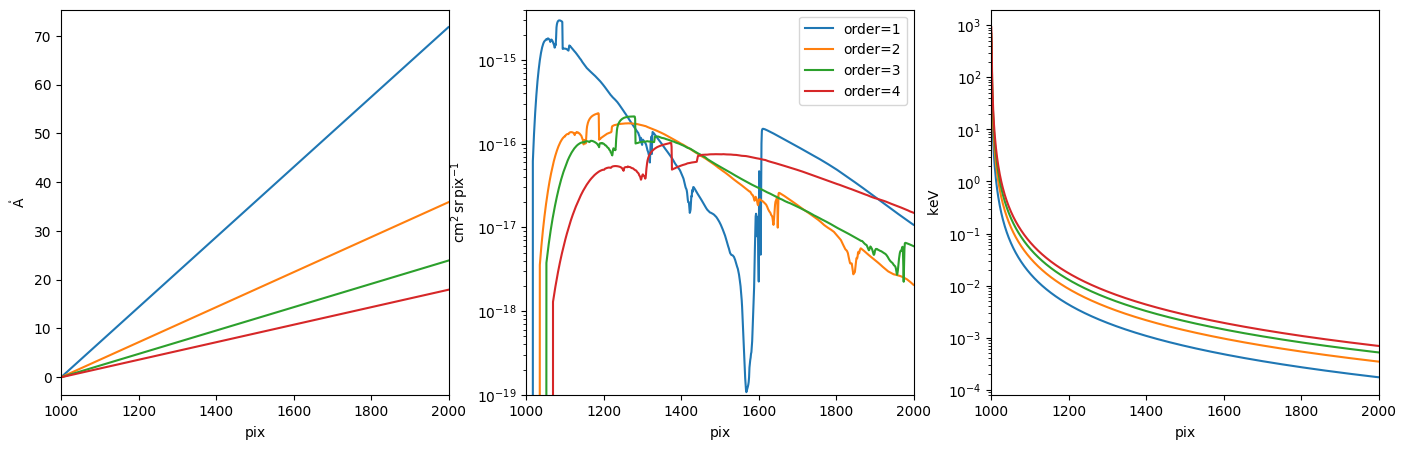

In [5]:
with quantity_support():
    fig = plt.figure(figsize=(17,5))
    ax1 = fig.add_subplot(131)
    ax2 = fig.add_subplot(132)
    ax3 = fig.add_subplot(133)
    for i in range(1,5):
        ax1.plot(table['dispersion_pixel'], table[f'wavelength_order_{i}'])
        ax2.plot(table['dispersion_pixel'], table[f'effective_area_order_{i}'], label=f'order={i}')
        ax3.plot(table['dispersion_pixel'], table[f'energy_resolution_order_{i}'])
    ax2.set_yscale('log')
    ax1.set_xlim(1000,2000)
    ax2.set_xlim(1000,2000)
    ax2.set_ylim(1e-19,4e-15)
    ax3.set_xlim(1000,2000)
    ax3.set_yscale('log')
    ax2.legend()